## Computing the Casimir energy between two spheres

In [1]:
import bempp.api
import math
import numpy as np
from numpy.linalg import slogdet
from bempp.api.assembly.blocked_operator import BlockedOperator
bempp.core.opencl_kernels.set_default_device(0,0)

In [2]:
NZ = 15
lower_bd = 0.5  # lower bound of Z
upper_bd = 4.0  # upper bound of Z
surf_dist = np.linspace(lower_bd, upper_bd, NZ)

Nk = 15
lbound = .05    # lower bound of k in ik
ubound = 4      # upper bound of k in ik
quad_points = np.linspace(np.exp(-ubound), np.exp(-lbound), Nk)

h = .05   # size of the mesh (element)

In [ ]:
# Two unit spheres' case
result_k_sphere_sphere = np.empty(Nk, dtype='float64')
Casimir_energy_sphere_sphere = np.empty(NZ, dtype='float64')
for index1, point1 in enumerate(surf_dist):
    
    center1 = ((point1/2) + 1, 0, 0)
    center2 = (-((point1/2) + 1), 0, 0)

    sphere1 = bempp.api.shapes.sphere(h=h, origin=center1)
    sphere2 = bempp.api.shapes.sphere(h=h, origin=center2)
    
    rwg1 = bempp.api.function_space(sphere1, "RWG", 0)
    rwg2 = bempp.api.function_space(sphere2, "RWG", 0)

    snc1 = bempp.api.function_space(sphere1, "SNC", 0)
    snc2 = bempp.api.function_space(sphere2, "SNC", 0)
    
    for index2, point2 in enumerate(quad_points):
    
        wavenumber = -1j * np.log(point2)

        op11 = bempp.api.operators.boundary.maxwell.electric_field(rwg1, rwg1, snc1, wavenumber)
        op22 = bempp.api.operators.boundary.maxwell.electric_field(rwg2, rwg2, snc2, wavenumber)
        op21 = bempp.api.operators.boundary.maxwell.electric_field(rwg1, rwg2, snc2, wavenumber)
        op12 = bempp.api.operators.boundary.maxwell.electric_field(rwg2, rwg1, snc1, wavenumber)

        mat11 = op11.weak_form().A
        mat12 = op12.weak_form().A
        mat21 = op21.weak_form().A
        mat22 = op22.weak_form().A
        mat12_zero = np.zeros((mat11.shape[0],mat12.shape[1]))
        mat21_zero = np.zeros((mat22.shape[0],mat11.shape[1]))

        mat = np.real(np.block([[mat11,mat12],[mat21,mat22]]))    
        mat2 = np.real(np.block([[mat11,mat12_zero],[mat21_zero,mat22]]))
        combined = np.linalg.inv(mat2).dot(mat)
        sign, logdet = slogdet(combined)
        result_k_sphere_sphere[index2] = logdet
        
    Casimir_energy_sphere_sphere[index1] = np.trapz(-result_k_sphere_sphere / quad_points, quad_points) / (2 * np.pi)

### Asymptotic formula 

In [3]:
coeff_list  = [143/16, 0, 7947/160, 2065/32, 27705347/100800, 
               -55251/64, 1373212550401/144506880, -7583389/320, 
               -2516749144274023/44508119040, 274953589659739/275251200 ]

In [4]:
center_dist = np.linspace(2 + lower_bd, 2 + upper_bd, NZ)

asy_casimir_energy_sphere_sphere = np.empty(NZ, dtype='float64')

for i in range(NZ):
    asy_casimir_energy = 0
    for j in range(len(coeff_list)):
        asy_casimir_energy += (1/center_dist[i]**7) * coeff_list[j] * (1/center_dist[i]**j)
    asy_casimir_energy_sphere_sphere[i] = asy_casimir_energy/np.pi

In [5]:
asy_casimir_energy_sphere_sphere

array([1.27307776e-01, 3.04388845e-02, 8.88097446e-03, 3.12744966e-03,
       1.30285246e-03, 6.23568804e-04, 3.32259784e-04, 1.91799465e-04,
       1.17511850e-04, 7.53229883e-05, 5.00150569e-05, 3.41701231e-05,
       2.39043771e-05, 1.70635980e-05, 1.23958639e-05])

In [7]:
asy_casimir_energy_sphere_sphere = [1.27307776e-01, 3.04388845e-02, 8.88097446e-03, 3.12744966e-03,
       1.30285246e-03, 6.23568804e-04, 3.32259784e-04, 1.91799465e-04,
       1.17511850e-04, 7.53229883e-05, 5.00150569e-05, 3.41701231e-05,
       2.39043771e-05, 1.70635980e-05, 1.23958639e-05]

Casimir_energy_sphere_sphere_01 = [2.94853971e-02, 9.02908591e-03, 3.56088959e-03, 1.63278728e-03, 8.29084949e-04, 4.53560750e-04, 2.62821709e-04, 1.59468781e-04,
                                   1.00490939e-04, 6.53723438e-05, 4.36987549e-05, 2.99088562e-05, 2.08986651e-05, 1.48731473e-05, 1.07598028e-05]

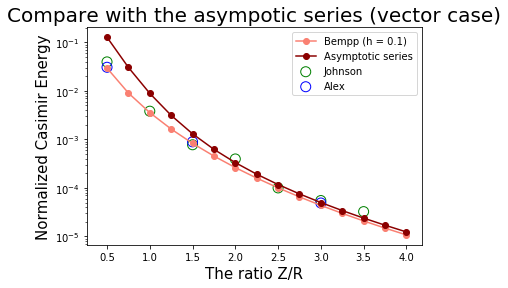

In [36]:
ref_x = [0.5,1,1.5,2,2.5,3,3.5]
ref_y = [0.03953125, 0.0038125, 0.000775 , 0.0003953125, 0.0001, 0.000055,0.0000325]
ref_Alex_x = [0.5, 1.5, 3]
ref_Alex_y = [0.030625, 0.000891542, 4.88718e-05]
plt.semilogy(surf_dist, Casimir_energy_sphere_sphere_01, color = 'salmon', linestyle = '-', marker = 'o')
plt.semilogy(surf_dist, asy_casimir_energy_sphere_sphere, color = 'darkred', linestyle = '-', marker = 'o')
plt.scatter(ref_x, ref_y, s=100, facecolors='none', edgecolors='g')
plt.scatter(ref_Alex_x, ref_Alex_y, s=100, facecolors='none', edgecolors='b')

plt.ylabel('Normalized Casimir Energy', fontsize = 15)
plt.legend(['Bempp (h = 0.1)','Asymptotic series', 'Johnson', 'Alex'], fontsize = 10)
plt.xlabel('The ratio Z/R',fontsize = 15)
plt.title('Compare with the asympotic series (vector case)', fontsize = 20)
plt.savefig('Asymp Vector.pdf', bbox_inches = 'tight')

In [11]:
relative_error_01 = []
for i in range(len(Casimir_energy_sphere_sphere_01)):
    relative_error_01.append(abs(Casimir_energy_sphere_sphere_01[i] - asy_casimir_energy_sphere_sphere[i])/asy_casimir_energy_sphere_sphere[i])

In [25]:
relative_error_Johnson = [abs(asy_casimir_energy_sphere_sphere[0] - ref_y[0])/asy_casimir_energy_sphere_sphere[0], 
                   abs(asy_casimir_energy_sphere_sphere[2] - ref_y[1])/asy_casimir_energy_sphere_sphere[2],
                    abs(asy_casimir_energy_sphere_sphere[4] - ref_y[2])/asy_casimir_energy_sphere_sphere[4],
                         abs(asy_casimir_energy_sphere_sphere[6] - ref_y[3])/asy_casimir_energy_sphere_sphere[6],
                         abs(asy_casimir_energy_sphere_sphere[8] - ref_y[4])/asy_casimir_energy_sphere_sphere[8],
                         abs(asy_casimir_energy_sphere_sphere[10] - ref_y[5])/asy_casimir_energy_sphere_sphere[10],
                         abs(asy_casimir_energy_sphere_sphere[12] - ref_y[6])/asy_casimir_energy_sphere_sphere[12]]

relative_error_Alex = [abs(asy_casimir_energy_sphere_sphere[0] - ref_Alex_y[0])/asy_casimir_energy_sphere_sphere[0], 
                   abs(asy_casimir_energy_sphere_sphere[4] - ref_Alex_y[1])/asy_casimir_energy_sphere_sphere[4],
                    abs(asy_casimir_energy_sphere_sphere[10] - ref_Alex_y[2])/asy_casimir_energy_sphere_sphere[10]]

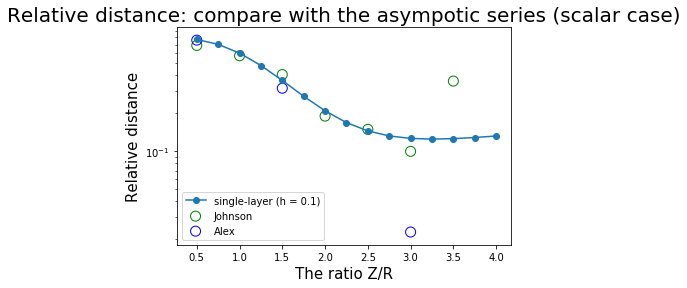

In [35]:
plt.semilogy(surf_dist, abs(np.array(relative_error_01)),  linestyle = '-', marker = 'o')
plt.scatter(ref_x, relative_error_Johnson , s=100, facecolors='none', edgecolors='g')
plt.scatter(ref_Alex_x, relative_error_Alex , s=100, facecolors='none', edgecolors='b')
plt.xlabel('The ratio Z/R', fontsize = 15)
plt.ylabel('Relative distance', fontsize = 15)
plt.legend(['single-layer (h = 0.1)', 'Johnson', 'Alex'], loc = 3, fontsize = 10)
plt.title('Relative distance: compare with the asympotic series (scalar case)', fontsize = 20)
plt.savefig('Asymp Vector rel dist.pdf', bbox_inches = 'tight')